In [1]:
import sys
sys.path.append('../utils')
from nd_tools import scale_img

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

The goal of this notebook is to visualize dual-pole backscatter images (HH, HV) as an RGB.

# Inspecting the data

In [2]:
data_dir = Path('../data')
backscatter_tifs = sorted(list(data_dir.glob('./*backscatter*.tif')))
backscatter_tifs

[PosixPath('../data/alos_backscatter_hh.tif'),
 PosixPath('../data/alos_backscatter_hv.tif')]

In [3]:
data_dir = Path('../data')
tv_tifs = sorted(list(data_dir.glob('./*tv.tif')))
tv_tifs

[PosixPath('../data/alos_hh_tv.tif'), PosixPath('../data/alos_hv_tv.tif')]

# RGB Composites

We are going to create an RGB composite following this [guide](http://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf). Specifically,

+ Red = HH
+ Green = HV
+ blue = (HH / HV)

We scale each channel so that it lies between 0 and 1 so it can be read as in image by matplotlib.

In [4]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one, backscatter_tifs))
eps = .00001
bands += [bands[0] / (bands[1] + eps)]

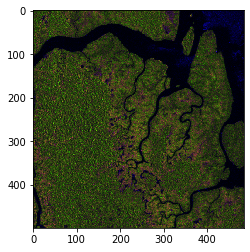

In [5]:
bands_scaled = list(map(scale_img, bands))
rgb = np.stack(bands_scaled, axis=2)
plt.imshow(rgb)

## Small Digression on scaling images

Above, we wanted to scale our image to 0 and 1 for viewing. What do we actually mean here?

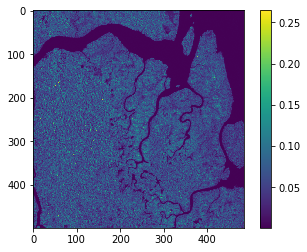

In [6]:
hh = bands[1]

plt.imshow(hh)
plt.colorbar()

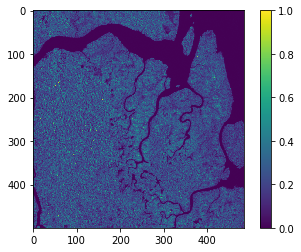

In [7]:
hh_scaled = bands_scaled[1]

plt.imshow(hh_scaled)
plt.colorbar()

## RGB from TV images

Use the TV Denoised Images to create an RGB image as before.

In [8]:
bands_tv = list(map(open_one, tv_tifs))
# So we don't divide by 0
eps = .00001
bands_tv += [bands_tv[0] / (bands_tv[1] + eps)]

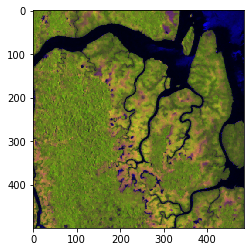

In [9]:
temp = list(map(scale_img, bands_tv))
rgb_tv = np.stack(temp, axis=2)
plt.imshow(rgb_tv)

In [10]:
with rasterio.open(tv_tifs[0]) as ds:
    profile = ds.profile
profile['count'] = 3
with rasterio.open(data_dir/'rgb.tif', 'w', **profile) as ds:
    ds.write(np.moveaxis(rgb_tv, 2, 0))

# ... and from dB

In [11]:
def open_one_db(path):
    with rasterio.open(path) as ds:
        band = 10 * np.log10(ds.read(1))
    return band


bands_db = list(map(open_one_db, tv_tifs))
eps = .00001
bands_db += [bands_db[0] / (bands_db[1] + eps)]

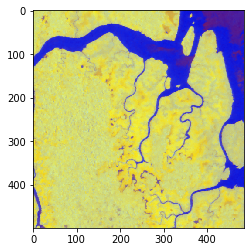

In [12]:
temp = list(map(scale_img, bands_db))
rgb_tv_db = np.stack(temp, axis=2)
plt.imshow(rgb_tv_db)

# Acknowledgements

This tutorial was written by Charlie Marshak and supervised closely by [Marc Simard](https://scholar.google.com/citations?user=JQJF1wgAAAAJ&hl=en). 

This tutorial was for the 2019 SARI training [conference](http://sari.umd.edu/meetings/international-regional-science-training) held at Prince of Songkla University, Phuket Campus. We are grateful to the conference organizers (in particular [Krishna Vadrevu](https://geog.umd.edu/facultyprofile/vadrevu/krishna)), the [SARI program](http://sari.umd.edu/), and the [LCLUC program](https://lcluc.umd.edu/) working to make this training conference possible. We are grateful for the input from and helpful conversations with [Michael Denbina](https://www.researchgate.net/profile/Michael_Denbina), [Tien-Hao Liao](https://scienceandtechnology.jpl.nasa.gov/tien-hao-liao), and Neda Kasraee. 

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2. We are also grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. 

Copyright 2019 by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government Sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.

This software may be subject to U.S. export control laws. By accepting this software, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required before exporting such information to foreign countries or providing access to foreign persons.
